In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.ticker as mtick

## Parse Data

In [ ]:
SP500 = pd.read_csv("./SPX_v1.csv")
SP500

,date,close
0,02-Jan-86,209.59
1,03-Jan-86,210.88
2,06-Jan-86,210.65
3,07-Jan-86,213.80
4,08-Jan-86,207.97
...,...,...
8187,25-Jun-18,2717.07
8188,26-Jun-18,2723.06
8189,27-Jun-18,2699.63
8190,28-Jun-18,2716.31


In [ ]:
def plot_line(data):
    fig1, ax1 = plt.subplots(figsize=(12,  3), constrained_layout=True)

    ax1.plot(data.index, data["close"], c="red")

    return None

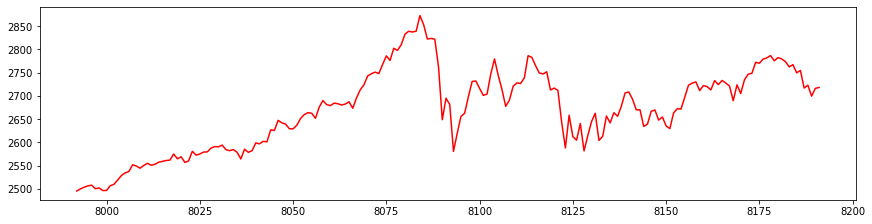

In [ ]:
plot_line(SP500[-200:])

In [ ]:
EURUSD = pd.read_csv("../input/EURUSD/EURUSD_15m_BID_01.01.2010-31.12.2016.csv")

market_closed_mask = EURUSD["Volume"] == 0
EURUSD = EURUSD[~market_closed_mask].reset_index()

EURUSD

,index,Time,Open,High,Low,Close,Volume
0,0,2010-01-01 00:00,1.43283,1.43293,1.43224,1.43293,6.086000e+08
1,1,2010-01-01 00:15,1.43285,1.43295,1.43229,1.43275,5.356000e+08
2,2,2010-01-01 00:30,1.43280,1.43303,1.43239,1.43281,4.363000e+08
3,3,2010-01-01 00:45,1.43285,1.43294,1.43229,1.43276,6.143000e+08
4,4,2010-01-01 01:00,1.43287,1.43292,1.43206,1.43282,7.053000e+08
...,...,...,...,...,...,...,...
174729,245335,2016-12-30 20:45,1.05358,1.05376,1.05238,1.05247,1.911700e+09
174730,245336,2016-12-30 21:00,1.05244,1.05251,1.05179,1.05180,8.912800e+08
174731,245337,2016-12-30 21:15,1.05179,1.05204,1.05141,1.05191,8.146200e+08
174732,245338,2016-12-30 21:30,1.05191,1.05193,1.05140,1.05156,4.275700e+08


In [ ]:
def plot_ohlc(data):
    fig1, ax1 = plt.subplots(figsize=(12,  3), constrained_layout=True)

    for i in data.index:
        ax1.vlines(i, ymin=data["Low"][i], ymax=data["High"][i], color="black", linewidth=2)
        if data["Close"][i] > data["Open"][i]:
            ax1.vlines(i, ymin=data["Open"][i], ymax=data["Close"][i], color="green", linewidth=4)
        elif data["Close"][i] < data["Open"][i]:
            ax1.vlines(i, ymin=data["Close"][i], ymax=data["Open"][i], color="red", linewidth=4)
        else:
            ax1.vlines(i, ymin=data["Open"][i], ymax=data["Close"][i]+0.000001, color="red", linewidth=4)

    return fig1, ax1

(<Figure size 864x216 with 1 Axes>, <AxesSubplot:>)

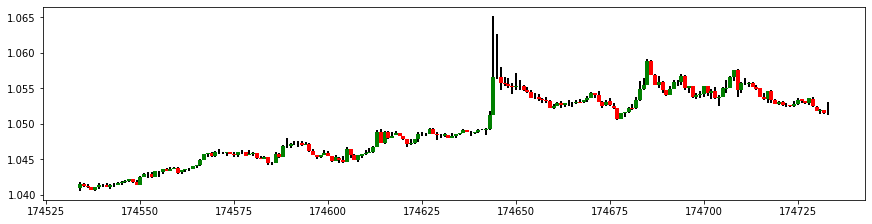

In [ ]:
plot_ohlc(EURUSD[-200:])

## Univariate

In [ ]:
x = np.reshape(SP500["close"].values, [len(SP500["close"]), 1])

# Feature Scaling
sc = MinMaxScaler(feature_range=(0, 1))
x = sc.fit_transform(x)

# Train Test Split
split = int(np.round(len(x) * 0.8, 0))

xx = []
yy = []

for i in range(10, len(x)-1):
    xx.append(x[i-10:i])
    yy.append(x[i])

xx = np.reshape(xx, (len(xx), len(xx[0]), 1))
yy = np.array(yy)

xt, xv = xx[:split], xx[split:]
yt, yv = yy[:split], yy[split:]

In [ ]:
univariate_SP500_LSTM_model = tf.keras.Sequential([
    tf.keras.layers.LSTM(25, return_sequences=True, input_shape=[xt.shape[0], 1]),
    tf.keras.layers.LSTM(25, return_sequences=True),
    tf.keras.layers.LSTM(25),
    tf.keras.layers.Dense(1)
])

univariate_SP500_LSTM_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
                                    loss="mse")
history = univariate_SP500_LSTM_model.fit(xt, yt, epochs=100, verbose=1,
                                          validation_data=(xv, yv),
                                          callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5)])

Epoch 1/100
205/205 [==============================] - 11s 28ms/step - loss: 0.0051 - val_loss: 0.0069
Epoch 2/100
205/205 [==============================] - 4s 19ms/step - loss: 8.7965e-05 - val_loss: 0.0070
Epoch 3/100
205/205 [==============================] - 4s 19ms/step - loss: 9.2512e-05 - val_loss: 0.0055
Epoch 4/100
205/205 [==============================] - 4s 19ms/step - loss: 9.1615e-05 - val_loss: 0.0058
Epoch 5/100
205/205 [==============================] - 4s 20ms/step - loss: 8.9660e-05 - val_loss: 0.0039
Epoch 6/100
205/205 [==============================] - 4s 19ms/step - loss: 1.0107e-04 - val_loss: 0.0018
Epoch 7/100
205/205 [==============================] - 4s 19ms/step - loss: 1.3193e-04 - val_loss: 0.0020
Epoch 8/100
205/205 [==============================] - 4s 19ms/step - loss: 6.2173e-05 - val_loss: 0.0011
Epoch 9/100
205/205 [==============================] - 4s 19ms/step - loss: 5.5383e-05 - val_loss: 9.7901e-04
Epoch 10/100
205/205 [=======================

In [ ]:
prediction = univariate_SP500_LSTM_model.predict(xv)

In [ ]:
def plot_training_loss(history):
    if "loss" in history.history.keys():
        fig1, ax1 = plt.subplots(figsize=(12, 3), constrained_layout=True)
        ax1.plot(history.history["loss"], label="MSE Train", color="blue")
        ax1.legend()
        ax1.grid()
        ax1.set_title("Loss Function", fontsize=15)
    if "val_loss" in history.history.keys():
        fig2, ax2 = plt.subplots(figsize=(12, 3), constrained_layout=True)
        ax2.plot(history.history["val_loss"], label="MSE Test", color="red")
        ax2.legend()
        ax2.grid()
        ax2.set_xlabel("Epoch", fontsize=15)
    return None

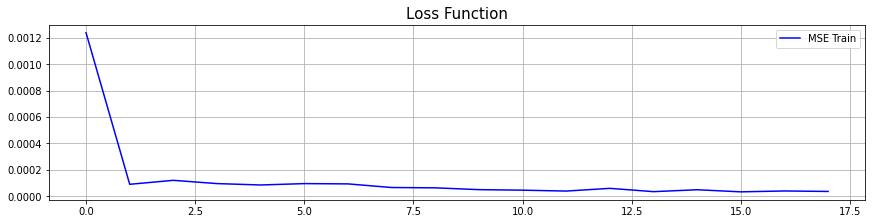

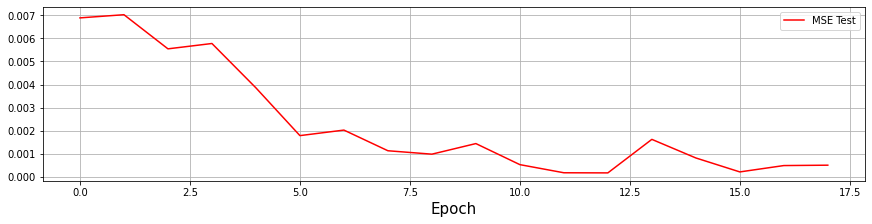

In [ ]:
plot_training_loss(history)

In [ ]:
def plot_predictions(actual, predicted):
    mse = tf.keras.metrics.mean_squared_error(actual, predicted)
    fig1, ax1 = plt.subplots(figsize=(12, 3), constrained_layout=True)
    ax1.plot(actual, label="Actual", color="blue")
    ax1.plot(predicted, label="Predicted", color="red")
    ax1.legend()
    ax1.grid()
    ax1.set_title("MSE: {}".format(mse))
    return None

(1627,)
(1627,)


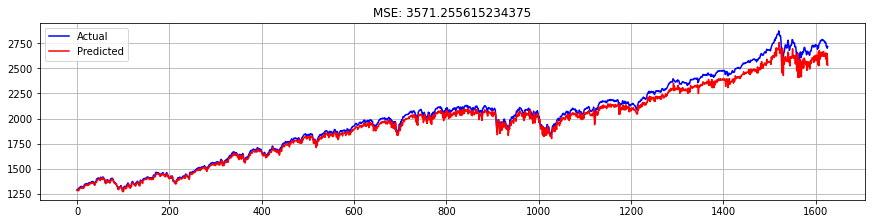

In [ ]:
actual = np.reshape(sc.inverse_transform(yv), -1)
prediction = np.reshape(sc.inverse_transform(prediction), -1)
print(prediction.shape)
print(actual.shape)
plot_predictions(actual, prediction)

## ARIMA-GARCH Signal

In [ ]:
!pip install arch
!pip install pmdarima

     |████████████████████████████████| 903 kB 6.4 MB/s eta 0:00:01
     |████████████████████████████████| 2.0 MB 7.8 MB/s eta 0:00:01
     |████████████████████████████████| 15.7 MB 52.3 MB/s eta 0:00:01
     |████████████████████████████████| 9.9 MB 35.0 MB/s eta 0:00:01
     |████████████████████████████████| 233 kB 51.1 MB/s eta 0:00:01
     |████████████████████████████████| 53 kB 1.4 MB/s  eta 0:00:01
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
  Attempting uninstall: patsy
    Found existing installation: patsy 0.5.1
    Uninstalling patsy-0.5.1:
      Successfully uninstalled patsy-0.5.1
  Attempting uninstall: packaging
    Found existing installation: packaging 20.9
    Uninstalling packaging-20.9:
      Successfully uninstalled packaging-20.9
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.12.2
    Uninstalling statsmodels-0.12.2:
   

In [ ]:
from arch import arch_model
import pmdarima as pm
from statsmodels.tsa.arima.model import ARIMA

ValueError: numpy.ndarray size changed, may indicate binary incompatibility. Expected 88 from C header, got 80 from PyObject

In [ ]:
def plot_arima_forecast(actual, pred_obj, train=[]):
    fig1, ax1 = plt.subplots(figsize=(12,  3), constrained_layout=True)

    l, u = pred.conf_int().columns
    lower = pred_obj.conf_int()[l]
    upper = pred_obj.conf_int()[u]

    x_label = np.arange(pred_obj.conf_int().index.start, pred_obj.conf_int().index.stop)

    if len(train):
        ax1.plot(train, label="Train", color="black")
    ax1.plot(actual, label="Actual", color="red")
    ax1.plot(pred_obj.predicted_mean, label="Predicted", color="blue")
    ax1.fill_between(x_label, upper, lower, color="grey", alpha=0.5)
    ax1.legend()

    return None

In [ ]:
ss = 100
fc = 20
returns = []
n_positions = 0
first_fc_day = 0
last_fc_day = 0
entry_price = None
exit_price = None
closes = EURUSD["Close"]
fc_bound = []

import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter("ignore", ConvergenceWarning)
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", RuntimeWarning)

start = closes.index[-2000]
stop = closes.index[-1]-fc-ss+1

for i in range(start, stop):
    if not len(fc_bound):
        train = closes[i:i+ss]
        test = closes[i+ss:i+ss+fc]
        auto_arima = pm.auto_arima(train, seasonal=False, max_p=3, max_q=3,
                                   stepwise=False, trace=False, suppress_warnings=True, error_action="ignore")
        arima = ARIMA(train, order=auto_arima.order).fit()
        pred = arima.get_forecast(fc, alpha=0.05)

        fc_bound = pred.conf_int()
        first_fc_day = fc_bound.index[0]
        last_fc_day = fc_bound.index[-1]

        l, u = fc_bound.columns
        lower = fc_bound[l]
        upper = fc_bound[u]

        returns.append(1)
        continue
    if i < last_fc_day:
        returns.append(1)
        continue
    elif i == last_fc_day:
        for j in range(first_fc_day, last_fc_day+1):
            if closes[j] <= lower[j]: # buy signal
                entry_price = closes[j]
                exit_price = closes[last_fc_day]
                n_positions += 1
                r = exit_price / entry_price
                returns.append(r)
                plot_arima_forecast(test, pred, train)
                break
            elif closes[j] >= upper[j]: # sell signal
                entry_price = closes[j]
                exit_price = closes[last_fc_day]
                n_positions += 1
                r = entry_price / exit_price
                returns.append(r)
                plot_arima_forecast(test, pred, train)
                break
        while len(returns) < last_fc_day:
            returns.append(1)
        # reset
        fc_bound = []
        entry_price = None
        exit_price = None
    # in between prompt #
    print("Index at:", i, "/", len(closes)-1)

NameError: name 'pm' is not defined

In [ ]:
# Return Statistics
returns = np.array(returns)
equity = np.cumprod(returns)
quality = np.sum(returns > 1) / n_positions

fig, ax = plt.subplots(figsize=(12, 6), constrained_layout=True)

ax.plot(equity, color="blue")
ax.set_title("Equity Return / Signal quality: {:.2%}".format(quality))
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0, decimals=2))
ax.grid()

<hr>

## ETS

In [ ]:
from statsmodels.tsa.exponential_smoothing.ets import ETSModel

In [ ]:
def plot_ets_forecast(actual, pred_df, train=[]):
    fig1, ax1 = plt.subplots(figsize=(12,  3), constrained_layout=True)

    pred_mean = pred_df.mean(axis=1)
    upper = pred_df.quantile(0.975, axis=1)
    lower = pred_df.quantile(0.025, axis=1)

    x_label = np.arange(pred_df.index.start, pred_df.index.stop)

    if len(train):
        ax1.plot(train, label="Train", color="black")
    ax1.plot(actual, label="Actual", color="red")
    ax1.plot(pred_mean, label="Predicted", color="blue")
    ax1.fill_between(x_label, upper, lower, color="grey", alpha=0.5)
    ax1.legend()

    return None

In [ ]:
def auto_ets(y, error=None, trend=None, damped_trend=None):
    models = []

    ee = [error] if error else ["add", "mul"]
    tt = [trend] if trend else ["add", "mul", None]
    dd = [damped_trend] if damped_trend else [True, False]

    for e in ee:
        for t in tt:
            for d in dd:
                if not t and d:
                    continue
                ets_model = ETSModel(y, error=e, trend=t, damped_trend=d)
                ets = ets_model.fit()
                models.append([ets_model, ets.aic])
    return sorted(models, key=lambda x: x[1])[0]

In [ ]:
ss = 100
fc = 20
returns = []
n_positions = 0
first_fc_day = 0
last_fc_day = 0
entry_price = None
exit_price = None
closes = EURUSD["Close"]
fc_bound = []

import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter("ignore", ConvergenceWarning)
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", RuntimeWarning)

start = closes.index[-10000]
stop = closes.index[-1]-fc-ss+1

for i in range(start, stop):
    # in between prompt #
    if not len(fc_bound):
        print("Index at:", i, "/", stop)
    if not len(fc_bound):
        train = closes[i:i+ss]
        test = closes[i+ss:i+ss+fc]
        ets_model, _ = auto_ets(train)
        ets = ets_model.fit()
        pred_df = ets.simulate(anchor="end", nsimulations=fc, repetitions=100)

        fc_bound = pred_df
        first_fc_day = fc_bound.index[0]
        last_fc_day = fc_bound.index[-1]

        lower = pred_df.quantile(0.025, axis=1)
        upper = pred_df.quantile(0.975, axis=1)

        returns.append(1)
        continue
    if i < last_fc_day:
        returns.append(1)
        continue
    elif i == last_fc_day:
        for j in range(first_fc_day, last_fc_day+1):
            if closes[j] <= lower[j]: # buy signal
                entry_price = closes[j]
                exit_price = closes[last_fc_day]
                n_positions += 1
                r = exit_price / entry_price
                plot_ets_forecast(test, pred_df, train)
                break
            elif closes[j] >= upper[j]: # sell signal
                entry_price = closes[j]
                exit_price = closes[last_fc_day]
                n_positions += 1
                r = entry_price / exit_price
                plot_ets_forecast(test, pred_df, train)
                break
        else:
            r = 1
        returns.append(r)
        # reset
        fc_bound = []
        entry_price = None
        exit_price = None

In [ ]:
# Return Statistics
returns = np.array(returns)
equity = np.cumprod(returns)
quality = np.sum(returns > 1) / n_positions

fig, ax = plt.subplots(figsize=(12, 6), constrained_layout=True)

x_label = np.arange(start, stop)

ax.plot(x_label, equity, color="blue")
ax.set_title("Equity Return / Signal quality: {:.2%}".format(quality))
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0, decimals=2))
ax.grid()

## Multistep

In [ ]:
x = np.reshape(SP500["close"].values, [len(SP500["close"]), 1])

# Feature Scaling
sc = MinMaxScaler(feature_range=(0, 1))
x = sc.fit_transform(x)

# Train Test Split
split = int(np.round(len(x) * 0.8, 0))

xx = []
yy = []

for i in range(10, len(x)-1):
    xx.append(x[i-10:i])
    yy.append(x[i+1])

xx = np.reshape(xx, (len(xx), len(xx[0]), 1))
yy = np.array(yy)

xt, xv = xx[:split], xx[split:]
yt, yv = yy[:split], yy[split:]

In [ ]:
xt.shape